In [36]:
import torch
from training.FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model)

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=40, bias=True)
      (1): ReLU()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): ReLU()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): ReLU()
      (6): Linear(in_features=40, out_features=40, bias=True)
      (7): ReLU()
      (8): Linear(in_features=40, out_features=40, bias=True)
      (9): ReLU()
      (10): Linear(in_features=40, out_features=40, bias=True)
      (11): ReLU()
      (12): Linear(in_features=40, out_features=40, bias=True)
      (13): ReLU()
      (14): Linear(in_features=40, out_features=40, bias=True)
      (15): ReLU()
      (16): Linear(in_features=40, out_features=40, bias=True)
      (17): ReLU()
      (18): Linear(in_features=40, out_features=40, bias=True)
      (19): ReLU()
      (20): Linear(in_features=40, out_features=40, bias=True)
      (21): ReLU()
      (22): Linear(in_features=40, ou

In [37]:
import pandas as pd

df = pd.read_csv("../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last 500 rows
df = df.tail(500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [38]:
import joblib

x_scaler = joblib.load("../models/x_scaler.save")
y_scaler = joblib.load("../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [39]:
test_output = compiled_model(x_scaled)

test_output

tensor([[0.1081],
        [0.1190],
        [0.1024],
        [0.0932],
        [0.0956],
        [0.0933],
        [0.1003],
        [0.0923],
        [0.0929],
        [0.0885],
        [0.1021],
        [0.0923],
        [0.0972],
        [0.1035],
        [0.1027],
        [0.0988],
        [0.1021],
        [0.1127],
        [0.1025],
        [0.1083],
        [0.1070],
        [0.0818],
        [0.0883],
        [0.0900],
        [0.0922],
        [0.0918],
        [0.0935],
        [0.1735],
        [0.2462],
        [0.1687],
        [0.0719],
        [0.1205],
        [0.0762],
        [0.0865],
        [0.0900],
        [0.0996],
        [0.0745],
        [0.0759],
        [0.0725],
        [0.0839],
        [0.0831],
        [0.0862],
        [0.0627],
        [0.1489],
        [0.0368],
        [0.0493],
        [0.0577],
        [0.0652],
        [0.0474],
        [0.0699],
        [0.1096],
        [0.0715],
        [0.0629],
        [0.0524],
        [0.0552],
        [0

In [40]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[1417.15392118],
       [1558.65638211],
       [1342.75478836],
       [1221.59505283],
       [1253.84379768],
       [1223.34769104],
       [1315.34112483],
       [1209.50629723],
       [1217.9696053 ],
       [1160.8062751 ],
       [1338.10005302],
       [1209.77158255],
       [1274.73324255],
       [1356.40178648],
       [1345.4431701 ],
       [1295.47152824],
       [1338.08800446],
       [1477.22076859],
       [1343.77130123],
       [1419.85882129],
       [1402.0953719 ],
       [1072.54742541],
       [1157.77605288],
       [1179.52036692],
       [1208.7778211 ],
       [1204.05296587],
       [1225.98049334],
       [2271.57386398],
       [3222.74174493],
       [2208.527053  ],
       [ 943.11808103],
       [1578.48627003],
       [ 999.29255443],
       [1134.75018706],
       [1179.38590237],
       [1305.44538503],
       [ 976.7238107 ],
       [ 995.14761569],
       [ 951.07484956],
       [1100.09581499],
       [1089.41568329],
       [1130.039

In [41]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

410.91917010901847

Text(0, 0.5, 'Fire Area (sqkm)')

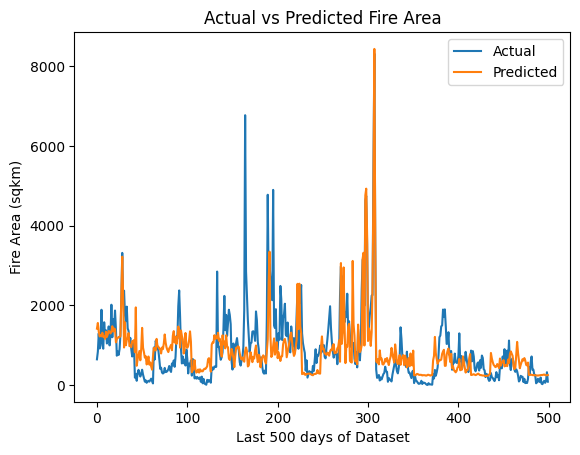

In [42]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")